## Images of the Dataset
Downloading of X-ray images of GDXray that are used in these examples.

In [ ]:
!mkdir ~/GDXray
!mkdir ~/GDXray/Baggages

!wget https://www.dropbox.com/s/swysmbjjuhnwpq6/B0044.zip
!unzip -oq B0044.zip  # Force to overwrite facilitates running the notebook without interactive actions
!rm B0044.zip
!rsync -av B0044 ~/GDXray/Baggages/

print('Images of series B0044 of GDXray have been downloaded and stored in directory GDXray/.')


--2021-09-27 14:48:19--  https://www.dropbox.com/s/swysmbjjuhnwpq6/B0044.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/swysmbjjuhnwpq6/B0044.zip [following]
--2021-09-27 14:48:20--  https://www.dropbox.com/s/raw/swysmbjjuhnwpq6/B0044.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc160fe481eec7db26675e6d3d86.dl.dropboxusercontent.com/cd/0/inline/BW_ogW1eHz61aUQx1RF-ahdxZeOoCbAmltD8Ol_NB8AY60jhRbRmcpnj23StpRpJuapWbS-qsPadq0GDG_-jm_HNMf6yu42TuS6NDdExk2a0X3U1FcIbHlq_k37wdqF_AgfoxI6RwbK5O_42XeS_mcHF/file# [following]
--2021-09-27 14:48:20--  https://uc160fe481eec7db26675e6d3d86.dl.dropboxusercontent.com/cd/0/inline/BW_ogW1eHz61aUQx1RF-ahdxZeOoCbAmltD8Ol_NB8AY60jhRbRmcpnj23StpRpJuapWbS-qsPadq0GDG_-jm_HNMf6yu42TuS6

In [ ]:
# Load calibrated projection matrices
import scipy.io as sio
!wget https://www.dropbox.com/s/es2k1qx1v6qle37/Pmatrices.mat
data = sio.loadmat('Pmatrices.mat')

--2021-09-27 14:48:29--  https://www.dropbox.com/s/es2k1qx1v6qle37/Pmatrices.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/es2k1qx1v6qle37/Pmatrices.mat [following]
--2021-09-27 14:48:29--  https://www.dropbox.com/s/raw/es2k1qx1v6qle37/Pmatrices.mat
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe9b5839468aba6184154789f3.dl.dropboxusercontent.com/cd/0/inline/BW8zk65USvwuFWzqzPdLZx64EdejgWBle9rF2TInBbWP6FDuQwcG6pY8wtNLTYI7AMv0SWoEPezy-Ir4gJtzlYpFdlu6MD7VJzyzDVKwH3HzjtFx1c5r5yrdprmQ249yZ7t6MHvZL7RQMNrVwe55WSyo/file# [following]
--2021-09-27 14:48:30--  https://ucfe9b5839468aba6184154789f3.dl.dropboxusercontent.com/cd/0/inline/BW8zk65USvwuFWzqzPdLZx64EdejgWBle9rF2TInBbWP6FDuQwcG6pY8wtNLTYI7AMv0SWoEPezy-Ir4gJtzlYp

## Installation of Libraries

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from cv2 import imread, IMREAD_GRAYSCALE

# Trifocal Geometry

This example shows how to estimate the coordinates of a corresponding point in view $r$ if we know the trifocal tensors and corresponding points $m_p$ and $m_q$ in views $p$ and $q$ respectively. This code computes the trifocal tensors from the projection matrices ${\bf P}_p$, ${\bf P}_q$ and ${\bf P}_r$. The reprojection is computed using: 

$
\lambda {\bf \hat m}_r  = 
({\bf T}^1 - x_q {\bf T}^3){\bf m}_p = 
({\bf T}^2 - y_q {\bf T}^3){\bf m}_p. 
$


In [ ]:
def estimate_trifocal_tensor(mat_a, mat_b, mat_c):
    """

    :param mat_a:
    :param mat_b:
    :param mat_c:
    :return:
    """

    mat_h = np.vstack([mat_a, np.random.rand(1, 4)])
    while np.abs(np.linalg.det(mat_h)) < 0.001:
        mat_h = np.vstack([mat_a, np.random.rand(1, 4)])
        if np.linalg.det(mat_h) < 0.001:
            print('Warning: determinant of H in trifocal estimation is zero')

    a = np.dot(mat_a, np.linalg.pinv(mat_h))
    b = np.dot(mat_b, np.linalg.pinv(mat_h))  # b = B * inv(H)
    c = np.dot(mat_c, np.linalg.pinv(mat_h))  # c = C * inv(H)

    tt = np.zeros((3, 3, 3))

    for i in range(3):
        for j in range(3):
            for k in range(3):
                tt[i, j, k] = b[j, i] * c[k, 3] - b[j, 3] * c[k, i]

    return tt

def reproject_trifocal(m1, m2, tensor, method=2):
    """

    Args:
        m1: 2D point in image 1
        m2: 2D point in image 2
        tensor: 
        method:
    
    Returns:
        m3: a 2D points in image 3
    """

    # Assert that m1 and m2 are homogeneous.
    m1 = m1 / m1[-1, :]
    m2 = m2 / m2[-1, :]

    n = m1.shape[-1]
    m3 = np.zeros((3, n))

    for k in range(n):
        temp = tensor[:, 0, :] - m2[0, k] * tensor[:, 2, :]
        m3[:, k] = (temp.T @ m1[:, k][:, np.newaxis]).ravel()


    m3 = m3 / m3[-1, :]

    if method == 2:
        m32 = np.zeros((3, n))
        for k in range(n):
            temp = tensor[:, 1, :] - m2[1, k] * tensor[:, 2, :]
            m32[:, k] = (temp.T @ m1[:, k][:, np.newaxis]).ravel()

        m32 = m32 / m32[-1, :]
        m3 = (m3 + m32) / 2

    return m3

def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st



Projection Matrices:
P1 =  [[-7.96593955e+03 -1.20081318e+03  5.35587150e+00  1.29786479e+06]
 [-2.15860979e+01 -1.28491171e+03 -7.95823608e+03  1.06426593e+06]
 [-1.43537660e-02 -9.99895554e-01  1.68838178e-03  9.64055869e+02]]
P2 =  [[ 7.91917914e+03  1.47808896e+03  5.35587150e+00  1.29786479e+06]
 [-2.32698237e+01  1.28488232e+03 -7.95823608e+03  1.06426593e+06]
 [-2.05508295e-02  9.99787384e-01  1.68838178e-03  9.64055869e+02]]
P3 =  [[-6.93605800e+03 -4.09746807e+03  5.35587150e+00  1.29786479e+06]
 [ 4.61322116e+02 -1.19943568e+03 -7.95823608e+03  1.06426593e+06]
 [ 3.61258887e-01 -9.32464029e-01  1.68838178e-03  9.64055869e+02]]


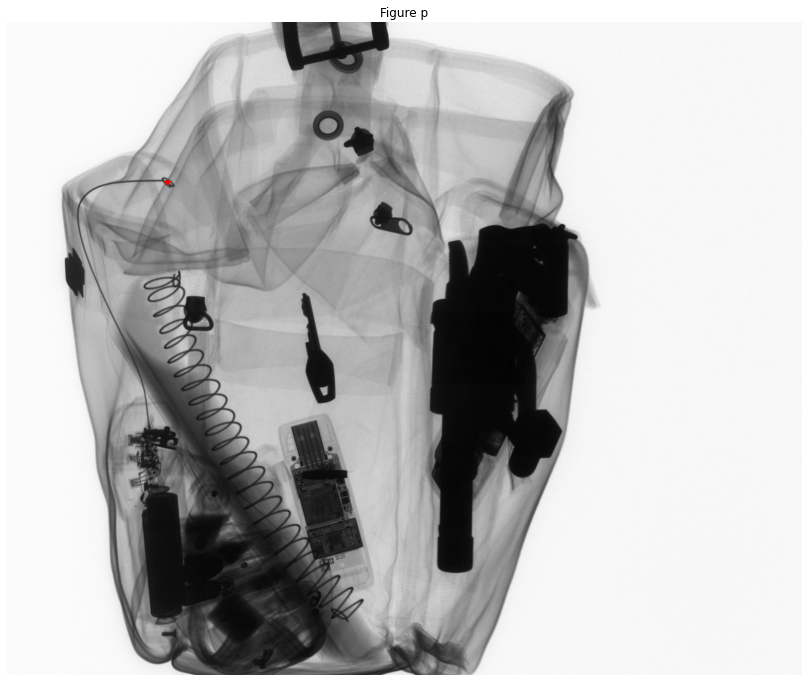

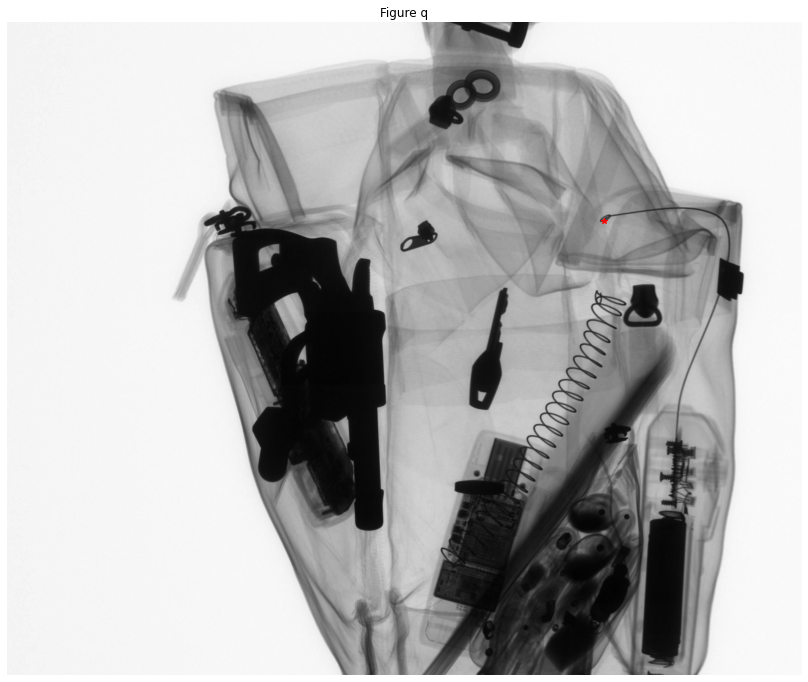

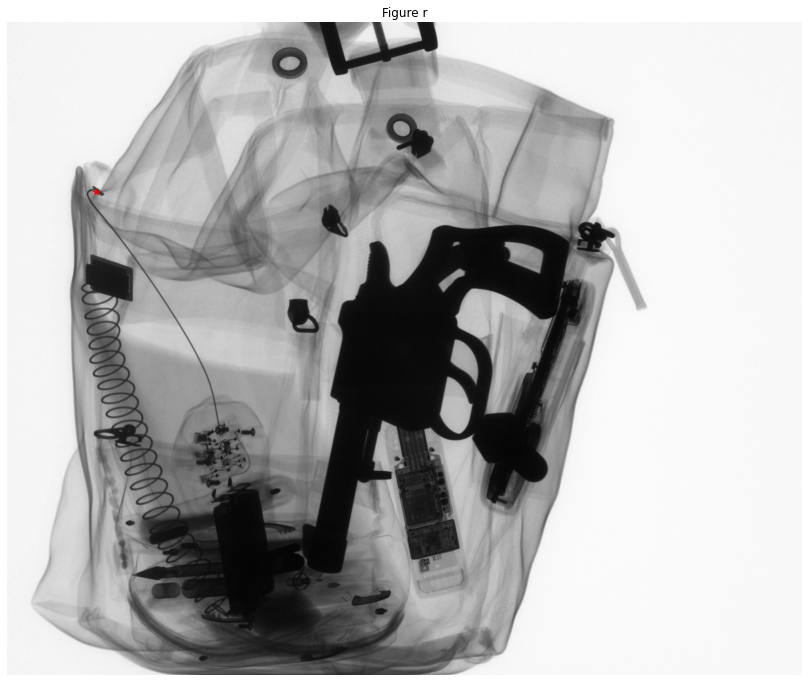

In [ ]:

p, q, r = (1, 90, 170)  # Indices for p, q, and r

# Load projection matrices for views p, q, r
P1 = data['P'][:, :, p]  # Reprojection matrix of view p
P2 = data['P'][:, :, q]  # Reprojection matrix of view q
P3 = data['P'][:, :, r]

print('Projection Matrices:')
print('P1 = ',P1)
print('P2 = ',P2)
print('P3 = ',P3)

Ip = imread('B0044/B0044_'+num2fixstr(p,4)+'.png', IMREAD_GRAYSCALE)
Iq = imread('B0044/B0044_'+num2fixstr(q,4)+'.png', IMREAD_GRAYSCALE)
Ir = imread('B0044/B0044_'+num2fixstr(r,4)+'.png', IMREAD_GRAYSCALE)

T = estimate_trifocal_tensor(P1, P2, P3)

# Plot lines and plot on figures
#print('Click a point in Figure 1 ...')
fig1, ax1 = plt.subplots(1, 1, subplot_kw=dict(title='Figure p'),figsize=(18,12))
ax1.imshow(Ip, cmap='gray')
ax1.axis('off')

#mp = np.hstack([np.array(plt.ginput(1)), np.ones((1, 1))]).T  # Click

# clicked pixel in image 'p'
mp = np.ones((3,1))
mp[0] = 542
mp[1] = 539

ax1.plot(mp[0], mp[1], 'r*')
fig1.canvas.draw()

#print('Click a point in Figure 2 ...')
fig2, ax2 = plt.subplots(1, 1, subplot_kw=dict(title='Figure q'),figsize=(18,12))
ax2.imshow(Iq, cmap='gray')
ax2.axis('off')

#mq = np.hstack([np.array(plt.ginput(1)), np.ones((1, 1))]).T  # Click
# clicked pixel in image 'q'
mq = np.ones((3,1))
mq[0] = 2020
mq[1] = 672


ax2.plot(mq[0], mq[1], 'r*')
fig2.canvas.draw()

mr = reproject_trifocal(mp, mq, T)  # reprojection of mr from mp, mq and T

fig3, ax3 = plt.subplots(1, 1, subplot_kw=dict(title='Figure r'),figsize=(18,12))
ax3.imshow(Ir, cmap='gray')
ax3.axis('off')
ax3.plot(mr[0, 0], mr[1, 0], 'r*')
fig3.canvas.draw()

plt.show()


The code uses two functions of PyXvis: `estimate_trifocal_tensor` to compute the trifocal tensors and `reproject_trifocal` to compute the reprojection of $m_r$. The example uses images $p=1$, $q=90$ and $r=170$ of series B0044 of GDXray. In this set of images there are 178 different views (taken by rotating the test object around a quasi vertical axis in $2^0$ between consecutive views). The reader that is interested in other views can change the code in order to define other values for $p$, $q$ and $r$.